# Imports

In [ ]:
!pip install -U tqdm gdown timm vit_pytorch transformers

In [1]:
import os
import random
import shutil
import zipfile

import gdown
import matplotlib.pyplot as plt
import numpy as np
import timm
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from tqdm.auto import tqdm
from transformers import DeiTForImageClassification

try:
    from google.colab import drive
    usesColab = True
except:
    usesColab = False
    pass

print('Dependencies loaded.')
print("===================================================")

if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print('Cuda available: {}'.format(torch.cuda.is_available()))
    print("GPU: " + torch.cuda.get_device_name(torch.cuda.current_device()))
    print("Total memory: {:.1f} GB".format((float(torch.cuda.get_device_properties(0).total_memory / (1024 ** 3)))))
else:
    device = torch.device("cpu")
    print('Cuda not available, so using CPU. Please consider switching to a GPU runtime before running the notebook!')
    
print("===================================================")
print(F"Torch version: {torch.__version__}")
print(F"Torchvision version: {torchvision.__version__}")
print("===================================================")

Dependencies loaded.
Cuda available: True
GPU: NVIDIA GeForce RTX 3060
Total memory: 12.0 GB
Torch version: 2.0.0+cu118
Torchvision version: 0.15.1+cu118


# Dataset initialization

In [4]:
# Dataset Download
dataset_dict = {
    "pwc_paperDataset": '10lDT4ZjuRfYKb4bTNK5gHNf7994bKg4-',    # PWC-Net | Real & Face2Face
    "raft_customDataset":'1ErjiegdRs7F6iqKD7S4bmVv5-i-RfqPK',   # Raft | Real & Custom Dataset
    "gma_customDataset":'1T_47yz1E5UlHOl6w8dHcaEZAONdGU3ww',    # GMA | Real & Custom Dataset
}

Dataset_name = "raft_customDataset"

In [5]:
ID = dataset_dict[Dataset_name]
output = 'Dataset.zip'

datasetDirectory = "Dataset"
if not (os.path.exists(datasetDirectory)):
  os.makedirs(datasetDirectory)

dataset_url = 'https://drive.google.com/uc?id=' + ID + '&export=download&confirm=t'
gdown.download(dataset_url, output, quiet=False)

with zipfile.ZipFile(output) as zf:
    for member in tqdm(zf.infolist(), desc='Extracting '):
        try:
            zf.extract(member, datasetDirectory)
        except zipfile.error as e:
            pass

print('Deleting the previous downloaded zip.')
os.remove('Dataset.zip')
print('Done.')

Downloading...
From: https://drive.google.com/uc?id=1ErjiegdRs7F6iqKD7S4bmVv5-i-RfqPK&export=download&confirm=t
To: c:\Users\Gianmarco\Documents\Git\DeepFakeDetectionOF\training models\Dataset.zip
100%|██████████| 625M/625M [02:01<00:00, 5.14MB/s] 
Extracting : 100%|██████████| 42004/42004 [00:19<00:00, 2111.46it/s]

Deleting the previous downloaded zip.
Done.


# Model

## DeITForImageClassification (Data-Efficient Image Transformer)

In [2]:
model = DeiTForImageClassification.from_pretrained("facebook/deit-base-distilled-patch16-384")
modelName = 'DeiT'

Some weights of the model checkpoint at facebook/deit-base-distilled-patch16-384 were not used when initializing DeiTForImageClassification: ['cls_classifier.bias', 'cls_classifier.weight', 'distillation_classifier.weight', 'distillation_classifier.bias']
- This IS expected if you are initializing DeiTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DeiTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-384 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream t

In [4]:
# Replace the last fully connected layer
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 2, device=device)

# Freeze pre-trained layers
for n, p in model.named_parameters():
    if(n.startswith("classifier")):
        p.requires_grad = True
    else:
        p.requires_grad = False
    #print(F"Parameter: {n} | Requires grad: {p.requires_grad}")

model = model.to(device)

num_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
formatted_num_parameters = '{0:,}'.format(num_parameters).replace(',', '.')
print(f"Number of trainable parameters: {formatted_num_parameters}")

Number of trainable parameters: 1.538


## ViT (Vision Transformer)

In [2]:
class PatchEmbedding(nn.Module):
    """Split image into patches and then embed them.
    Parameters
    ----------
    img_size : int
        Size of the image (it is a square).
    patch_size : int
        Size of the patch (it is a square).
    in_chans : int
        Number of input channels.
    embed_dim : int
        The emmbedding dimension.
    Attributes
    ----------
    n_patches : int
        Number of patches inside of our image.
    proj : nn.Conv2d
        Convolutional layer that does both the splitting into patches
        and their embedding.
    """
    def __init__(self, img_size, patch_size, in_chans=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2

        # We take the kernel size and the stride and we put
        # both of them equal to the patch size.
        # This way, when we're sliding the kernel along the
        # input tensor, we'll never slide it in an overlapping way
        # and the kernel will exactly "fall" into these patches
        # that we're trying to divide our image into.
        self.proj = nn.Conv2d(
                in_chans,
                embed_dim,
                kernel_size=patch_size,
                stride=patch_size,
        )

    def forward(self, x):
        """Run forward pass.
        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, in_chans, img_size, img_size)`.
        # ======================================== #
        N.B! ---> n_samples is equal to batch_size!
        # ======================================== #
        Returns
        -------
        torch.Tensor
        n_patches is the number of patches we divided the image into
        and the last dimension will be the embedding dimension.
            Shape `(n_samples, n_patches, embed_dim)`.
        """

        # We first run the projection (Conv2D), returing a 4D dimensional Tensor
        # Then we take the last 2 dimensions of self.proj (which represent
        # the grid of patches and we flatten them into a single 1D dimension.
        # At the end, we simply swap the 1st dimension with the 2nd (PyTorch).
        x = self.proj(x)        # (n_samples, embed_dim, n_patches ** 0.5, n_patches ** 0.5)
        x = x.flatten(2)        # (n_samples, embed_dim, n_patches)
        x = x.transpose(1, 2)   # (n_samples, n_patches, embed_dim)

        return x
    
class Attention(nn.Module):
    """Attention mechanism.
    Parameters
    ----------
    dim : int
        The input and out dimension of per token features.
    n_heads : int
        Number of attention heads.
    bias : bool
        If True then we include bias to the query, key and value projections.
    attnDropoutRate : float
        Dropout probability applied to the query, key and value tensors.
    dropoutRateOutput : float
        Dropout probability applied to the output tensor.
    Attributes
    ----------
    scale : float
        Normalizing consant for the dot product.
    qkv : nn.Linear
        Linear projection for the query, key and value.
    proj : nn.Linear
        Linear mapping that takes in the concatenated output of all attention
        heads and maps it into a new space.
    attn_drop, proj_drop : nn.Dropout
        Dropout layers.
    """
    def __init__(self, dim, n_heads=12, bias=True, attnDropoutRate=0., dropoutRateOutput=0.):
        super().__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.head_dim = dim // n_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=bias)
        self.attn_drop = nn.Dropout(attnDropoutRate)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(dropoutRateOutput)

    def forward(self, x):
        """Run forward pass.
        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.
        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.
        """
        n_samples, n_tokens, dim = x.shape

        if dim != self.dim:
            raise ValueError

        qkv = self.qkv(x)                                                       # (n_samples, n_patches + 1, 3 * dim)
        qkv = qkv.reshape(n_samples, n_tokens, 3, self.n_heads, self.head_dim)  # (n_samples, n_patches + 1, 3, n_heads, head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)                                        # (3, n_samples, n_heads, n_patches + 1, head_dim)

        q, k, v = qkv[0], qkv[1], qkv[2]

        k_t = k.transpose(-2, -1)                                               # (n_samples, n_heads, head_dim, n_patches + 1)
        dp = (q @ k_t) * self.scale                                             # (n_samples, n_heads, n_patches + 1, n_patches + 1)

        attn = dp.softmax(dim=-1)                                               # (n_samples, n_heads, n_patches + 1, n_patches + 1)
        attn = self.attn_drop(attn)                                             # Dropout to Attention Layer

        weighted_avg = attn @ v                                                 # (n_samples, n_heads, n_patches +1, head_dim)
        weighted_avg = weighted_avg.transpose(1, 2)                             # (n_samples, n_patches + 1, n_heads, head_dim)
        weighted_avg = weighted_avg.flatten(2)                                  # (n_samples, n_patches + 1, dim)

        x = self.proj(weighted_avg)                                             # (n_samples, n_patches + 1, dim)
        x = self.proj_drop(x)                                                   # (n_samples, n_patches + 1, dim)

        return x

class MLP(nn.Module):
    """Multilayer perceptron.
    Parameters
    ----------
    in_features : int
        Number of input features.
    hidden_features : int
        Number of nodes in the hidden layer.
    out_features : int
        Number of output features.
    p : float
        Dropout probability.
    Attributes
    ----------
    fc : nn.Linear
        The First linear layer.
    gelu : nn.GELU
        GELU activation function.
    fc2 : nn.Linear
        The second linear layer.
    drop : nn.Dropout
        Dropout layer.
    """
    def __init__(self, in_features, hidden_features, out_features, p=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.gelu = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(p)

    def forward(self, x):
        """Run forward pass.
        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, n_patches + 1, in_features)`.
        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches +1, out_features)`
        """
        x = self.fc1(x)     # (n_samples, n_patches + 1, hidden_features)
        x = self.gelu(x)    # (n_samples, n_patches + 1, hidden_features)
        x = self.drop(x)    # (n_samples, n_patches + 1, hidden_features)
        x = self.fc2(x)     # (n_samples, n_patches + 1, out_features)
        x = self.drop(x)    # (n_samples, n_patches + 1, out_features)

        return x
    
class Block(nn.Module):
    """Transformer block.
    Parameters
    ----------
    dim : int
        Embeddinig dimension.
    n_heads : int
        Number of attention heads.
    mlp_ratio : float
        Determines the hidden dimension size of the `MLP` module with respect
        to `dim`.
    qkv_bias : bool
        If True then we include bias to the query, key and value projections.
    p, dropoutRateAttention : float
        Dropout probability.
    Attributes
    ----------
    norm1, norm2 : LayerNorm
        Layer normalization.
    attn : Attention
        Attention module.
    mlp : MLP
        MLP module.
    """
    def __init__(self, dim, n_heads, mlp_ratio=4.0, bias=True, p=0., dropoutRateAttention=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim, eps=1e-6)
        self.attn = Attention(
                dim,
                n_heads=n_heads,
                bias=bias
        )
        self.norm2 = nn.LayerNorm(dim, eps=1e-6)
        hidden_features = int(dim * mlp_ratio)
        self.mlp = MLP(
                in_features=dim,
                hidden_features=hidden_features,
                out_features=dim,
        )

    def forward(self, x):
        """Run forward pass.
        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.
        Returns
        -------
        torch.Tensor
            Shape `(n_samples, n_patches + 1, dim)`.
        """
        res_x_1 = x

        x = self.norm1(x)
        x = self.attn(x)
        x = x + res_x_1

        res_x_2 = x

        x = self.norm2(x)
        x = self.mlp(x)
        x = x + res_x_2

        return x

class VisionTransformer(nn.Module):
    """Simplified implementation of the Vision transformer.
    Parameters
    ----------
    img_size : int
        Both height and the width of the image (it is a square).
    patch_size : int
        Both height and the width of the patch (it is a square).
    in_chans : int
        Number of input channels.
    n_classes : int
        Number of classes.
    embed_dim : int
        Dimensionality of the token/patch embeddings.
    depth : int
        Number of blocks.
    n_heads : int
        Number of attention heads.
    mlp_ratio : float
        Determines the hidden dimension of the `MLP` module.
    qkv_bias : bool
        If True then we include bias to the query, key and value projections.
    p, dropoutRateAttention : float
        Dropout probability.
    Attributes
    ----------
    patch_embed : PatchEmbed
        Instance of `PatchEmbed` layer.
    cls_token : nn.Parameter
        Learnable parameter that will represent the first token in the sequence.
        It has `embed_dim` elements.
    pos_emb : nn.Parameter
        Positional embedding of the cls token + all the patches.
        It has `(n_patches + 1) * embed_dim` elements.
    pos_drop : nn.Dropout
        Dropout layer.
    blocks : nn.ModuleList
        List of `Block` modules.
    norm : nn.LayerNorm
        Layer normalization.
    """
    def __init__(
            self,
            img_size=384,
            patch_size=16,
            in_chans=3,
            n_classes=1000,
            embed_dim=768,
            depth=12,
            n_heads=12,
            mlp_ratio=4.,
            bias=True,
            p=0.,
            dropoutRateAttention=0.,
    ):
        super().__init__()

        self.patch_embed = PatchEmbedding(
                img_size=img_size,
                patch_size=patch_size,
                in_chans=in_chans,
                embed_dim=embed_dim,
        )
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + self.patch_embed.n_patches, embed_dim)        )
        self.pos_drop = nn.Dropout(p=p)

        self.blocks = nn.ModuleList(
            [
                Block(
                    dim=embed_dim,
                    n_heads=n_heads,
                    mlp_ratio=mlp_ratio,
                    bias=bias,
                    p=p,
                    dropoutRateAttention=dropoutRateAttention,
                )
                for _ in range(depth)
            ]
        )

        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.head = nn.Linear(embed_dim, n_classes)

    def forward(self, x):
        """Run the forward pass.
        Parameters
        ----------
        x : torch.Tensor
            Shape `(n_samples, in_chans, img_size, img_size)`.
        Returns
        -------
        logits : torch.Tensor
            Logits over all the classes - `(n_samples, n_classes)`.
        """
        n_samples = x.shape[0]
        x = self.patch_embed(x)

        cls_token = self.cls_token.expand(n_samples, -1, -1)    # (n_samples, 1, embed_dim)
        x = torch.cat((cls_token, x), dim=1)                    # (n_samples, 1 + n_patches, embed_dim)
        x = x + self.pos_embed                                  # (n_samples, 1 + n_patches, embed_dim)
        x = self.pos_drop(x)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)

        cls_token_final = x[:, 0]                               # Just the CLS token
        x = self.head(cls_token_final)

        return x

In [3]:
# ===================================   C O N F I G U R A T I O N S   ====================================== #
# If you pass an input shape of (1280, 720) to a pre-trained ViT model that was trained on smaller           #
# image sizes like 224 or 384, it will result in a large number of patches, and the model may not be able    #
# to handle the increased computational and memory requirements. Additionally, the larger input size may     #
# not have the same spatial information as the smaller input sizes that the model was trained on,            #
# which can lead to reduced accuracy.                                                                        #
#                                                                                                            #
# In summary, it's generally recommended to use input shapes that are similar to the shapes that the model   #
# was trained on to ensure good performance and accuracy. If you need to process larger input sizes,         #
# you may need to consider using a different model architecture or training the model on larger input sizes. #
# ========================================================================================================== #

# Load the configurations
# Define the configuration dictionaries for each model

vit_tiny_patch16_224 = { # ViT-Tiny (Vit-Ti/16)
    "img_size": 224,
    "patch_size": 16,
    "embed_dim": 192,
    "depth": 12,
    "n_heads": 3,
}

vit_tiny_patch16_384 = { # ViT-Tiny (Vit-Ti/16) @ 384x384
    "img_size": 384,
    "patch_size": 16,
    "embed_dim": 192,
    "depth": 12,
    "n_heads": 3,
}

vit_small_patch16_224 = { # ViT-Small (ViT-S/16)
    "img_size": 224,
    "patch_size": 16,
    "embed_dim": 384,
    "depth": 12,
    "n_heads": 6,
}

vit_small_patch16_384 = { # ViT-Small (ViT-S/16) @ 384x384
    "img_size": 384,
    "patch_size": 16,
    "embed_dim": 384,
    "depth": 12,
    "n_heads": 6,
}

vit_small_patch32_224 = { # ViT-Small (ViT-S/32)
    "img_size": 224,
    "patch_size": 32,
    "embed_dim": 384,
    "depth": 12,
    "n_heads": 6,   
}

vit_small_patch32_384 = { # ViT-Small (ViT-S/32) @ 384x384
    "img_size": 384,
    "patch_size": 32,
    "embed_dim": 384,
    "depth": 12,
    "n_heads": 6,   
}

vit_small_patch8_224 = { # ViT-Small (ViT-S/8)
    "img_size": 224,
    "patch_size": 8,
    "embed_dim": 384,
    "depth": 12,
    "n_heads": 6,   
}

vit_base_patch32_224 = { # ViT-Base (ViT-B/32) -> Original
    "img_size": 224,
    "patch_size": 32,
    "embed_dim": 768,
    "depth": 12,
    "n_heads": 12,   
}

vit_base_patch32_384 = { # ViT-Base (ViT-B/32) @ 384x384
    "img_size": 384,
    "patch_size": 32,
    "embed_dim": 768,
    "depth": 12,
    "n_heads": 12,   
}

vit_base_patch16_224 = { # ViT-Base (ViT-B/16)
    "img_size": 224,
    "patch_size": 16,
    "embed_dim": 768,
    "depth": 12,
    "n_heads": 12,   
}

vit_base_patch16_384 = { # ViT-Base (ViT-B/16) @ 384x384
    "img_size": 384,
    "patch_size": 16,
    "embed_dim": 768,
    "depth": 12,
    "n_heads": 12,   
}

vit_base_patch8_224 = { # ViT-Base (ViT-B/8)
    "img_size": 224,
    "patch_size": 8,
    "embed_dim": 768,
    "depth": 12,
    "n_heads": 12,   
}

vit_large_patch32_224 = { # ViT-Large model (ViT-L/32)
    "img_size": 224,
    "patch_size": 32,
    "embed_dim": 1024,
    "depth": 24,
    "n_heads": 16,       
}

vit_large_patch32_384 = { # ViT-Large model (ViT-L/32) @ 384x384
    "img_size": 384,
    "patch_size": 32,
    "embed_dim": 1024,
    "depth": 24,
    "n_heads": 16,       
}

vit_large_patch16_224 = { # ViT-Large model (ViT-L/16)
    "img_size": 224,
    "patch_size": 16,
    "embed_dim": 1024,
    "depth": 24,
    "n_heads": 16,         
}

vit_large_patch16_384 = { # ViT-Large model (ViT-L/16) @ 384x384
    "img_size": 384,
    "patch_size": 16,
    "embed_dim": 1024,
    "depth": 24,
    "n_heads": 16,         
}
# Define a dictionary that maps the model names to their corresponding configuration dictionaries
config_dict = {
    "vit_tiny_patch16_224": vit_tiny_patch16_224,
    "vit_tiny_patch16_384": vit_tiny_patch16_384,
    "vit_small_patch8_224": vit_small_patch8_224,
    "vit_small_patch16_224": vit_small_patch16_224,
    "vit_small_patch16_384": vit_small_patch16_384,
    "vit_small_patch32_224": vit_small_patch32_224,
    "vit_small_patch32_384": vit_small_patch32_384,
    "vit_base_patch8_224": vit_base_patch8_224,
    "vit_base_patch16_224": vit_base_patch16_224,
    "vit_base_patch16_384": vit_base_patch16_384,
    "vit_base_patch32_224": vit_base_patch32_224,
    "vit_base_patch32_384": vit_base_patch32_384,
    "vit_large_patch16_224": vit_large_patch16_224,
    "vit_large_patch16_384": vit_large_patch16_384,
    "vit_large_patch32_224": vit_large_patch32_224,
    "vit_large_patch32_384": vit_large_patch32_384,
}

In [4]:
# Define a global variable to set the default model name
#   - vit_tiny_patch16_224  | ViT-Tiny  (Vit-Ti/16)
#   - vit_tiny_patch16_384  | ViT-Tiny  (Vit-Ti/16) @ 384x384
#   - vit_small_patch8_224  | ViT-Small (Vit-S/8)
#   - vit_small_patch16_224 | ViT-Small (ViT-S/16)
#   - vit_small_patch16_384 | ViT-Small (ViT-S/16) @ 384x384
#   - vit_small_patch32_224 | ViT-Small (ViT-S/32)
#   - vit_small_patch32_384 | ViT-Small (ViT-S/32) @ 384x384
#   - vit_base_patch8_224   | ViT-Base  (ViT-B/8)
#   - vit_base_patch16_224  | ViT-Base  (ViT-B/16)
#   - vit_base_patch16_384  | ViT-Base  (ViT-B/16) @ 384x384
#   - vit_base_patch32_224  | ViT-Base  (ViT-B/32) -> Original
#   - vit_base_patch32_384  | ViT-Base  (ViT-B/32) @ 384x384
#   - vit_large_patch16_224 | ViT-Large (ViT-L/16)
#   - vit_large_patch16_384 | ViT-Large (ViT-L/16) @ 384x384
#   - vit_large_patch32_224 | ViT-Large (ViT-L/32)
#   - vit_large_patch32_384 | ViT-Large (ViT-L/32) @ 384x384

# Shape of Transformer (224 or 384) must match the Dataset's images shape!
# If Transformer == "vit_base_patch16_224" (for example), then images of Dataset should be resized to (224,224)
# If Transformer == "vit_base_patch16_384" (for example), then images of Dataset should be resized to (384,384)
modelName = F"vit_small_patch16_384"
num_classes = 2
custom_config = config_dict[modelName]
custom_config.update({'n_classes': num_classes, 
                      'bias': True,
                      'mlp_ratio': 4})

### Training from scratch

In [ ]:
model = VisionTransformer(**custom_config)

for (customNames, customParameters) in model.named_parameters():
        customParameters.requires_grad = True
        print(F"Parameter: {customNames}\t| Trainable: {customParameters.requires_grad}")

model = model.to(device=device)

### Load the pre-trained weights (ImageNet)

In [5]:
modelHugging = timm.create_model(modelName, pretrained=True, num_classes=num_classes)

model = VisionTransformer(**custom_config)

trainableLayers = ['head.weight', 'head.bias']

for (huggingNames, huggingParameters), (customNames, customParameters) in zip(modelHugging.named_parameters(), model.named_parameters()):

    assert huggingParameters.numel() == customParameters.numel()

    customParameters.data[:] = huggingParameters.data

    np.testing.assert_allclose(customParameters.data.detach().numpy(), huggingParameters.data.detach().numpy())

    if(customNames in trainableLayers):
        customParameters.requires_grad = True
    else:
        customParameters.requires_grad = False
    #print(F"Parameter: {customNames}\t| Trainable: {customParameters.requires_grad}")

model = model.to(device)

num_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
formatted_num_parameters = '{0:,}'.format(num_parameters).replace(',', '.')
print(f"Number of trainable parameters: {formatted_num_parameters}")

Number of trainable parameters: 770


# Helper functions

In [6]:
def loadModel(modelPath, isCheckpoint=True):
    bestAcc = 0.0
    startEpoch = 1

    if(isCheckpoint):
        print("You specified a pre-loading directory for a checkpoint.")
    else:
        print("You specified a pre-loading directory for a model.")

    if os.path.isfile(modelPath):
        print("=> Loading model '{}'".format(modelPath))
        modelLoaded = torch.load(modelPath)

        # State & Optimizer
        model.load_state_dict(modelLoaded["state_dict"], strict=False)

        # Best validations
        try:
            bestAcc = modelLoaded["best_val"]
            valAcc = modelLoaded["val_acc"]
            print(F"\t- Validation accuracy for this model: {valAcc:.5f}")
            print(F"\t- Best validation accuracy: {bestAcc:.5f}")
        except:
            print("\t- No best validation accuracy present in this model")
            pass

        if(isCheckpoint):
            optimizer.load_state_dict(modelLoaded["optimizer"])

            # Starting epoch
            try:
                startEpoch = modelLoaded["epoch"] + 1
                print(F"\t- Starting from epoch n.{startEpoch}")
            except:
                print("\t- No starting epoch present in this model")
                pass

        if(isCheckpoint):
            print("Checkpoint loaded successfully.")
        else:
            print("model loaded successfully.")
    else:
        if(isCheckpoint):
            print("=> No checkpoint found at '{}'".format(modelPath))
        else:
            print("=> No model found at '{}'".format(modelPath))

        print("Are you sure the directory / model exist? Exiting..")
        raise FileNotFoundError()

    print("===================================================")
    return bestAcc, startEpoch

def saveModel(state, is_best):
    if is_best:
        path = str(savePath) + '/best/' + F'{modelName}_best_epoch-{state["epoch"]}_accT-{state["train_acc"]:.5f}_accV-{state["val_acc"]:.5f}.pt'
    else:
        path = str(savePath) + '/checkpoint/' + F'{modelName}_checkpoint_epoch-{state["epoch"]}_accT-{state["train_acc"]:.5f}_accV-{state["val_acc"]:.5f}.pt'
    torch.save(state, path)
    return path

# Training

## Define parameters of the training phase

In [7]:
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
epochs = 50
batchSize = 64
# ============================================== #
savePath = os.path.join("save_path", modelName)
if not(os.path.exists(savePath)):
    os.makedirs(savePath)

## Define the Dataloaders

Training feature shape : torch.Size([64, 3, 384, 384])
Training labels shape  : torch.Size([64])
----------------------------------------------
Test feature shape     : torch.Size([64, 3, 384, 384])
Test labels shape      : torch.Size([64])
Lenght train loader: 460
Lenght test loader: 197


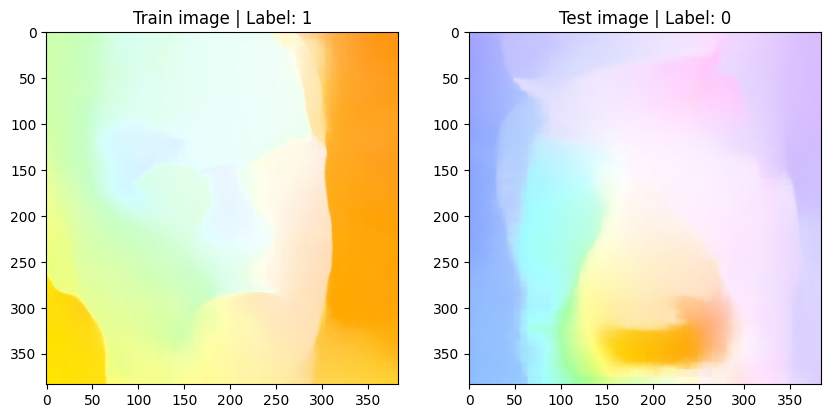

In [8]:
# Define data transformations
transformTrain = transforms.Compose([
    transforms.RandomHorizontalFlip(0.20),
    #transforms.CenterCrop(300),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transformsTest = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define paths for train_dir and test_dir according to split perfomed on OFs dataset
train_dir = os.path.join("Dataset", "train")
test_dir = os.path.join("Dataset", "test")

# Load the ImageFolder datasets for train and test directories
train_dataset = ImageFolder(root=train_dir, transform=transformTrain)
test_dataset = ImageFolder(root=test_dir, transform=transformsTest)

# Create data loaders for the train and test subsets
train_loader = DataLoader(train_dataset, batch_size=batchSize, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batchSize, shuffle=False)

# Check the updated number of frames in each loader
train_features, train_labels = next(iter(train_loader))
print("===================================================")
print(f"Training feature shape : {train_features.size()}")
print(f"Training labels shape  : {train_labels.size()}")
print('----------------------------------------------')
test_features, test_labels = next(iter(test_loader))
print(f"Test feature shape     : {test_features.size()}")
print(f"Test labels shape      : {test_labels.size()}")
print("===================================================")
print(f"Lenght train loader: {len(train_loader)}")
print(f"Lenght test loader: {len(test_loader)}")
print("===================================================")

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Train Features
train_image = train_features[0]
axes[0].imshow(train_image.permute(1, 2, 0))
axes[0].set_title(f"Train image | Label: {train_labels[0]}")

# Test Features
test_image = test_features[0]
axes[1].imshow(test_image.permute(1, 2, 0))
axes[1].set_title(f"Test image | Label: {test_labels[0]}")

plt.show()

## Google Drive implementation

In [ ]:
if(usesColab):
  drive.mount('/content/gdrive')

  bestPath = os.path.join(os.path.join("gdrive", "MyDrive", "Models", savePath, "best"))
  checkPath = os.path.join(os.path.join("gdrive", "MyDrive", "Models", savePath, "checkpoint"))
  if not (os.path.exists(bestPath)):
    os.makedirs(bestPath)
  if not (os.path.exists(checkPath)):
    os.makedirs(checkPath)

## Training Loop

In [9]:
load_model = False
modelPath = '' # e.g. 'save_path/ViT/best/ViT_best_epoch-1_accT-0.61361_accV-0.56974.pt'
               # or   '/content/gdrive/MyDrive/X/X/ViT_best_epoch-1_accT-0.61361_accV-0.56974.pt'

isCheckpoint = True

if(load_model):
  bestAcc, startEpoch = loadModel(modelPath, isCheckpoint=isCheckpoint)
else:
  bestAcc = 0.00
  startEpoch = 1

You specified a pre-loading directory for a checkpoint.
=> Loading model 'save_path/vit_small_patch16_384/checkpoint/vit_small_patch16_384_checkpoint_epoch-29_accT-0.59326_accV-0.58186.pt'
	- Validation accuracy for this model: 0.58186
	- Best validation accuracy: 0.58972
	- Starting from epoch n.30
Checkpoint loaded successfully.


In [ ]:
print("===================================================")
print(F"The directory for saving checkpoints/models is: {savePath}")
if not(os.path.exists(os.path.join(savePath, 'checkpoint'))):
    os.makedirs(os.path.join(savePath, 'checkpoint'))

if not(os.path.exists(os.path.join(savePath, 'best'))):
    os.makedirs(os.path.join(savePath, 'best'))
print("===================================================")

trainLosses = []
trainAccuracies = []
valLosses = []
valAccuracies = []

for epoch in range(startEpoch, epochs+1):
    # Training loop
    model.train()
    totalTrain = 0
    correctTrain = 0

    # Let's shuffle the dataset at every epoch for better generalization during the training phase
    #train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batchSize, shuffle=True)

    with tqdm(total=len(train_loader), desc=F'Epoch {epoch}/{epochs} | Training') as pbar:
        for i, data in enumerate(train_loader):
            images, labels = data

            images = images.to(device)
            labels = labels.to(device)

            # Empty the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            if(modelName == 'DeiT'):
                outputs = outputs.logits
            lTrain = criterion(outputs, labels)

            # Backward and optimize
            lTrain.backward()
            optimizer.step()

            # Accuracy
            _, outputs_rounded = torch.max(outputs.data, 1)
            correctTrain += (outputs_rounded == labels).sum().float()
            totalTrain += labels.size(0)

            pbar.set_postfix({'Loss': '{:.3f}'.format(lTrain.item()), 'Accuracy': '{:.3f}'.format((correctTrain / totalTrain)*100)})
            pbar.update()

    # Evaluation
    model.eval()
    with torch.no_grad():
        correctVal = 0
        totalVal = 0
        with tqdm(total=len(test_loader), desc=F'Epoch {epoch}/{epochs} | Test') as pbar:
            for i, data in enumerate(test_loader):
                images, labels = data

                images = images.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(images)
                if(modelName == 'DeiT'):
                    outputs = outputs.logits
                lVal = criterion(outputs, labels)

                # Accuracy
                _, outputs_rounded = torch.max(outputs.data, 1)
                correctVal += (outputs_rounded == labels).sum().float()
                totalVal += labels.size(0)

                pbar.set_postfix({'Loss': '{:.3f}'.format(lVal.item()), 'Accuracy': '{:.3f}'.format((correctVal / totalVal)*100)})
                pbar.update()

    # Losses computation
    train_loss_epoch = lTrain.item()
    val_loss_epoch = lVal.item()
    trainLosses.append(train_loss_epoch)
    valLosses.append(val_loss_epoch)

    # Accuracies computation
    train_acc_epoch = correctTrain / totalTrain
    val_acc_epoch = correctVal / totalVal
    trainAccuracies.append(train_acc_epoch.detach().cpu().numpy())
    valAccuracies.append(val_acc_epoch.detach().cpu().numpy())

    if(val_acc_epoch > bestAcc):
        isBest = True
        previousBestAcc = bestAcc
        bestAcc = val_acc_epoch
        print("\nVal Accuracy increased at epoch {}: {:.5f} --> {:.5f} |".format(epoch, previousBestAcc, bestAcc))
    else:
        isBest = False

    pathSaved = saveModel(state={
                    'epoch': epoch,
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                    'train_acc': train_acc_epoch,
                    'val_acc': val_acc_epoch,
                    'best_val': bestAcc
                },
                is_best=isBest)

    print('\nEpoch {}/{}:\n\tTrain Acc: {:.3f} (avg. {:.3f}) | Train Loss: {:.3f} (avg. {:.3f}) | \
        \n\tVal Acc  : {:.3f} (avg. {:.3f}) | Val Loss: {:.3f} (avg. {:.3f}) |'.format(epoch, epochs,
                                                                                    train_acc_epoch*100,
                                                                                    np.average(trainAccuracies)*100,
                                                                                    train_loss_epoch,
                                                                                    np.average(trainLosses),
                                                                                    val_acc_epoch*100,
                                                                                    np.average(valAccuracies)*100,
                                                                                    val_loss_epoch,
                                                                                    np.average(valLosses)))
    print("=========================================")
    if (usesColab):
        shutil.copy(pathSaved, os.path.join("gdrive", "MyDrive", "Models", pathSaved))
        print(F'Uploaded model in: {os.path.join("gdrive", "MyDrive", "Models", pathSaved)}')